# Assault (Atari) con DQN + PER

Este notebook entrena un agente DQN con Prioritized Experience Replay (PER) en ALE/Assault-v5.
Incluye preprocesamiento, checkpoints, logging con TensorBoard y evaluacion vs baseline aleatorio.

In [1]:
# Instalar dependencias (compatible con Colab)
!pip -q install gymnasium[atari,accept-rom-license] ale-py autorom torch tensorboard
!AutoROM --accept-license

import os
import json
import time
import subprocess
import numpy as np
import torch
import gymnasium as gym
import ale_py  # Registra el namespace ALE
from gymnasium.wrappers import RecordVideo

ROOT_DIR = os.getcwd()
ART_DIR = os.path.join(ROOT_DIR, "artifacts", "assault")
CKPT_DIR = os.path.join(ART_DIR, "checkpoints")
LOG_DIR = os.path.join(ART_DIR, "logs")
VIDEO_DIR = os.path.join(ART_DIR, "videos")
for d in [CKPT_DIR, LOG_DIR, VIDEO_DIR]:
    os.makedirs(d, exist_ok=True)

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Dispositivo:", DEVICE)
print("Torch:", torch.__version__)
print("Gymnasium:", gym.__version__)
try:
    print(subprocess.check_output(["nvidia-smi"]).decode())
except Exception:
    print("nvidia-smi no disponible")

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/bank_heist.bin
Inst

In [2]:
# Evidencia de hardware y versiones
import sys
import platform

print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("torch:", torch.__version__)
print("gymnasium:", gym.__version__)
print("ale_py:", ale_py.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU:", "No disponible")
try:
    print(subprocess.check_output(["nvidia-smi"]).decode())
except Exception as e:
    print("nvidia-smi no disponible:", e)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
torch: 2.9.0+cu128
gymnasium: 1.2.3
ale_py: 0.11.2
CUDA disponible: True
GPU: NVIDIA A100-SXM4-80GB
Sun Feb 15 00:05:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0         

In [3]:
# Implementaciones locales (sin importar src/)
import math
import glob
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
from gymnasium.wrappers import AtariPreprocessing, TransformReward


class SimpleFrameStack(gym.Wrapper):
    def __init__(self, env, num_stack=4):
        super().__init__(env)
        self.num_stack = num_stack
        self.frames = deque(maxlen=num_stack)
        low = np.repeat(env.observation_space.low[None, ...], num_stack, axis=0)
        high = np.repeat(env.observation_space.high[None, ...], num_stack, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=env.observation_space.dtype)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.num_stack):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        return np.stack(list(self.frames), axis=0)


def make_atari_env(
    game_id: str,
    seed: int,
    frame_skip: int = 4,
    clip_rewards: bool = False,
    render_mode: str | None = None,
 ):
    env = gym.make(
        game_id,
        frameskip=1,
        repeat_action_probability=0.0,
        render_mode=render_mode,
    )
    env = AtariPreprocessing(
        env,
        frame_skip=frame_skip,
        grayscale_obs=True,
        screen_size=84,
        scale_obs=False,
        terminal_on_life_loss=False,
    )
    if clip_rewards:
        env = TransformReward(env, lambda r: max(-1.0, min(1.0, r)))
    env = SimpleFrameStack(env, num_stack=4)
    env.reset(seed=seed)
    return env


class SumTree:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1, dtype=np.float32)
        self.data_pointer = 0

    @property
    def total(self) -> float:
        return float(self.tree[0])

    def add(self, priority: float):
        idx = self.data_pointer + self.capacity - 1
        self.update(idx, priority)
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        return idx

    def update(self, idx: int, priority: float) -> None:
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        parent = (idx - 1) // 2
        while True:
            self.tree[parent] += change
            if parent == 0:
                break
            parent = (parent - 1) // 2

    def get(self, s: float):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf = idx
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = leaf - self.capacity + 1
        return leaf, self.tree[leaf], data_idx


class PrioritizedReplayBuffer:
    def __init__(self, capacity: int, alpha: float = 0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)
        self.data = [None] * capacity
        self.max_priority = 1.0
        self.size = 0

    def add(self, obs, action, reward, next_obs, done):
        idx = self.tree.add(self.max_priority)
        if isinstance(obs, np.ndarray) and obs.dtype == np.uint8:
            obs_u8 = obs
        else:
            obs_u8 = (np.clip(obs, 0.0, 1.0) * 255.0).astype(np.uint8)
        if isinstance(next_obs, np.ndarray) and next_obs.dtype == np.uint8:
            next_obs_u8 = next_obs
        else:
            next_obs_u8 = (np.clip(next_obs, 0.0, 1.0) * 255.0).astype(np.uint8)
        self.data[idx - self.capacity + 1] = (obs_u8, action, reward, next_obs_u8, done)
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int, beta: float = 0.4):
        if self.tree.total == 0:
            raise ValueError("No hay prioridades en el buffer")
        indices = []
        priorities = []
        samples = []
        segment = self.tree.total / batch_size
        for i in range(batch_size):
            data = None
            for _ in range(20):
                s = np.random.uniform(segment * i, segment * (i + 1))
                idx, p, data_idx = self.tree.get(s)
                data = self.data[data_idx]
                if data is not None:
                    indices.append(idx)
                    priorities.append(p)
                    samples.append(data)
                    break
            if data is None:
                valid = [j for j, d in enumerate(self.data) if d is not None]
                data_idx = int(np.random.choice(valid))
                idx = data_idx + self.capacity - 1
                p = self.tree.tree[idx]
                indices.append(idx)
                priorities.append(p)
                samples.append(self.data[data_idx])
        probs = np.array(priorities, dtype=np.float32) / self.tree.total
        weights = (self.size * probs) ** (-beta)
        weights /= weights.max()
        obs, actions, rewards, next_obs, dones = map(np.array, zip(*samples))
        obs = obs.astype(np.float32) / 255.0
        next_obs = next_obs.astype(np.float32) / 255.0
        return obs, actions, rewards, next_obs, dones, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, p in zip(indices, priorities):
            priority = float(p) ** self.alpha
            self.tree.update(idx, priority)
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.size

    def state_dict(self):
        return {
            "capacity": self.capacity,
            "alpha": self.alpha,
            "tree": self.tree.tree.copy(),
            "data": self.data,
            "max_priority": self.max_priority,
            "size": self.size,
            "data_pointer": self.tree.data_pointer,
        }

    def load_state_dict(self, state):
        self.capacity = state["capacity"]
        self.alpha = state["alpha"]
        self.tree = SumTree(self.capacity)
        self.tree.tree = state["tree"]
        self.tree.data_pointer = state["data_pointer"]
        self.data = state["data"]
        self.max_priority = state["max_priority"]
        self.size = state["size"]


class EpsilonSchedule:
    def __init__(self, start: float, end: float, decay_steps: int):
        self.start = start
        self.end = end
        self.decay_steps = decay_steps

    def value(self, step: int) -> float:
        frac = min(step / self.decay_steps, 1.0)
        return self.start + frac * (self.end - self.start)


class PERBetaSchedule:
    def __init__(self, start: float, end: float, steps: int):
        self.start = start
        self.end = end
        self.steps = steps

    def value(self, step: int) -> float:
        frac = min(step / self.steps, 1.0)
        return self.start + frac * (self.end - self.start)


class QNetwork(nn.Module):
    def __init__(self, in_channels: int, num_actions: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class DQNPerAgent:
    def __init__(
        self,
        obs_shape,
        num_actions: int,
        device: str,
        gamma: float = 0.99,
        lr: float = 1e-4,
        target_update_interval: int = 10_000,
        buffer_size: int = 200_000,
        alpha: float = 0.6,
        eps_schedule: EpsilonSchedule | None = None,
        beta_schedule: PERBetaSchedule | None = None,
    ):
        self.device = device
        self.num_actions = num_actions
        self.gamma = gamma
        self.target_update_interval = target_update_interval
        self.step_count = 0

        in_channels = obs_shape[0]
        self.online = QNetwork(in_channels, num_actions).to(device)
        self.target = QNetwork(in_channels, num_actions).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.target.eval()

        self.optimizer = torch.optim.Adam(self.online.parameters(), lr=lr)
        self.replay = PrioritizedReplayBuffer(buffer_size, alpha=alpha)

        self.eps_schedule = eps_schedule or EpsilonSchedule(1.0, 0.05, 1_000_000)
        self.beta_schedule = beta_schedule or PERBetaSchedule(0.4, 1.0, 1_000_000)

    def select_action(self, obs: np.ndarray) -> int:
        eps = self.eps_schedule.value(self.step_count)
        if np.random.rand() < eps:
            return np.random.randint(self.num_actions)
        obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.online(obs_t)
        return int(torch.argmax(q_values, dim=1).item())

    def update(self, batch_size: int):
        if len(self.replay) < batch_size:
            return None

        beta = self.beta_schedule.value(self.step_count)
        obs, actions, rewards, next_obs, dones, indices, weights = self.replay.sample(batch_size, beta)

        obs_t = torch.tensor(obs, dtype=torch.float32, device=self.device)
        next_obs_t = torch.tensor(next_obs, dtype=torch.float32, device=self.device)
        actions_t = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)
        weights_t = torch.tensor(weights, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values_all = self.online(obs_t)
        q_values = q_values_all.gather(1, actions_t)
        with torch.no_grad():
            next_q = self.target(next_obs_t).max(dim=1, keepdim=True)[0]
            target = rewards_t + self.gamma * (1.0 - dones_t) * next_q

        td_error = target - q_values
        loss = F.smooth_l1_loss(q_values, target, reduction="none")
        loss = (loss * weights_t).mean()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online.parameters(), 10.0)
        self.optimizer.step()

        priorities = td_error.detach().abs().cpu().numpy().squeeze() + 1e-6
        self.replay.update_priorities(indices, priorities)

        if self.step_count % self.target_update_interval == 0:
            self.target.load_state_dict(self.online.state_dict())

        mean_q = float(q_values_all.mean().item())
        return float(loss.item()), float(td_error.detach().abs().mean().item()), mean_q, float(beta)

    def save_state(self):
        return {
            "online": self.online.state_dict(),
            "target": self.target.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "step_count": self.step_count,
            "replay": self.replay.state_dict(),
            "gamma": self.gamma,
            "target_update_interval": self.target_update_interval,
        }

    def load_state(self, state):
        self.online.load_state_dict(state["online"])
        self.target.load_state_dict(state["target"])
        self.optimizer.load_state_dict(state["optimizer"])
        self.step_count = int(state["step_count"])
        self.replay.load_state_dict(state["replay"])
        self.gamma = float(state.get("gamma", self.gamma))
        self.target_update_interval = int(state.get("target_update_interval", self.target_update_interval))


def save_checkpoint(state: dict, checkpoint_dir: str, step: int) -> str:
    os.makedirs(checkpoint_dir, exist_ok=True)
    ckpt_path = os.path.join(checkpoint_dir, f"checkpoint_{step}.pth")
    torch.save(state, ckpt_path)
    return ckpt_path


def load_checkpoint(ckpt_path: str, device: str):
    return torch.load(ckpt_path, map_location=device, weights_only=False)


def save_config(config: dict, checkpoint_dir: str) -> str:
    os.makedirs(checkpoint_dir, exist_ok=True)
    config_path = os.path.join(checkpoint_dir, "config.json")
    with open(config_path, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)
    return config_path


def get_latest_checkpoint(checkpoint_dir: str) -> str | None:
    pattern = os.path.join(checkpoint_dir, "checkpoint_*.pth")
    ckpts = glob.glob(pattern)
    if not ckpts:
        return None
    def _step(p):
        name = os.path.basename(p)
        step_str = name.replace("checkpoint_", "").replace(".pth", "")
        return int(step_str)
    ckpts.sort(key=_step)
    return ckpts[-1]

In [4]:
# Hiperparametros y configuracion
config = {
    "env_id": "ALE/Assault-v5",
    "frame_skip": 4,
    "clip_rewards": True,
    "total_steps": 2_000_000,
    "learning_starts": 50_000,
    "update_every": 4,
    "batch_size": 32,
    "buffer_size": 200_000,
    "gamma": 0.99,
    "lr": 1e-4,
    "target_update_interval": 10_000,
    "checkpoint_interval": 200_000,
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay_steps": 1_000_000,
    "beta_start": 0.4,
    "beta_end": 1.0,
    "beta_steps": 1_000_000,
    "alpha": 0.6,
    "seed": SEED
}
save_config(config, CKPT_DIR)

'/content/artifacts/assault/checkpoints/config.json'

In [5]:
# Crear entorno
env = make_atari_env(
    config["env_id"],
    seed=SEED,
    frame_skip=config["frame_skip"],
    clip_rewards=config["clip_rewards"],
)
num_actions = env.action_space.n
obs_shape = env.observation_space.shape
print("Obs shape:", obs_shape, "Acciones:", num_actions)

Obs shape: (4, 84, 84) Acciones: 7


In [6]:
# Diagnostico: wrappers y observaciones
def describe_env(env, label: str):
    print(f"[{label}] action_space={env.action_space}")
    print(f"[{label}] obs_shape={env.observation_space.shape}, dtype={env.observation_space.dtype}")
    print(f"[{label}] wrappers={env}")

describe_env(env, "train")

# Verificar un entorno de evaluacion con los mismos wrappers
eval_env_diag = make_atari_env(
    config["env_id"],
    seed=SEED + 999,
    frame_skip=config["frame_skip"],
    clip_rewards=config["clip_rewards"],
    render_mode=None,
)
describe_env(eval_env_diag, "eval")
eval_env_diag.close()

[train] action_space=Discrete(7)
[train] obs_shape=(4, 84, 84), dtype=uint8
[train] wrappers=<SimpleFrameStack<TransformReward<AtariPreprocessing<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Assault-v5>>>>>>>
[eval] action_space=Discrete(7)
[eval] obs_shape=(4, 84, 84), dtype=uint8
[eval] wrappers=<SimpleFrameStack<TransformReward<AtariPreprocessing<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Assault-v5>>>>>>>


In [7]:
# Agente
eps_schedule = EpsilonSchedule(
    config["eps_start"],
    config["eps_end"],
    config["eps_decay_steps"],
)
beta_schedule = PERBetaSchedule(
    config["beta_start"],
    config["beta_end"],
    config["beta_steps"],
)
agent = DQNPerAgent(
    obs_shape=obs_shape,
    num_actions=num_actions,
    device=DEVICE,
    gamma=config["gamma"],
    lr=config["lr"],
    target_update_interval=config["target_update_interval"],
    buffer_size=config["buffer_size"],
    alpha=config["alpha"],
    eps_schedule=eps_schedule,
    beta_schedule=beta_schedule,
)

In [8]:
# Writer de TensorBoard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)


def obs_to_array(obs):
    arr = np.asarray(obs)
    # Si ya viene en formato (C, H, W), no transponer
    if arr.ndim == 3 and arr.shape[0] in (1, 4):
        return arr
    # Si viene como (H, W, C), convertir a (C, H, W)
    if arr.ndim == 3:
        return np.transpose(arr, (2, 0, 1))
    return arr


def preprocess(obs):
    arr = obs_to_array(obs)
    return arr.astype(np.float32) / 255.0

In [9]:
# Loop de entrenamiento con checkpoints
resume_path = None  # define ruta de checkpoint para reanudar
if resume_path:
    state = load_checkpoint(resume_path, device=DEVICE)
    agent.load_state(state)
    print("Reanudado desde", resume_path)

obs, info = env.reset()
episode_reward = 0.0
episode_len = 0
episode_returns = deque(maxlen=100)
start_time = time.time()

for step in range(1, config["total_steps"] + 1):
    agent.step_count = step
    obs_proc = preprocess(obs)
    action = agent.select_action(obs_proc)
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    next_obs_proc = preprocess(next_obs)
    agent.replay.add(obs_proc, action, reward, next_obs_proc, float(done))
    episode_reward += reward
    episode_len += 1

    if step > config["learning_starts"] and step % config["update_every"] == 0:
        update_out = agent.update(config["batch_size"])
        if update_out is not None:
            loss, td_error, mean_q, beta_val = update_out
            writer.add_scalar("train/loss", loss, step)
            writer.add_scalar("train/td_error", td_error, step)
            writer.add_scalar("train/mean_q", mean_q, step)
            writer.add_scalar("train/beta", beta_val, step)

    eps_value = agent.eps_schedule.value(step)
    writer.add_scalar("train/epsilon", eps_value, step)
    writer.add_scalar("train/beta", agent.beta_schedule.value(step), step)

    if step % 200000 == 0:
        elapsed = time.time() - start_time
        sps = step / max(elapsed, 1e-6)
        mean_100 = float(np.mean(episode_returns)) if len(episode_returns) > 0 else 0.0
        print(
            f"Paso {step}/{config['total_steps']} | eps={eps_value:.3f} | ",
            f"return_ma100={mean_100:.2f} | {sps:.1f} steps/s",
        )

    if done:
        episode_returns.append(episode_reward)
        writer.add_scalar("rollout/episode_return", episode_reward, step)
        writer.add_scalar("rollout/episode_length", episode_len, step)
        if len(episode_returns) > 0:
            writer.add_scalar("rollout/episode_return_ma", float(np.mean(episode_returns)), step)
        obs, info = env.reset()
        episode_reward = 0.0
        episode_len = 0
    else:
        obs = next_obs

    if step % config["checkpoint_interval"] == 0:
        state = agent.save_state()
        ckpt_path = save_checkpoint(state, CKPT_DIR, step)
        print("Guardado", ckpt_path)

train_time = time.time() - start_time
print(f"Tiempo de entrenamiento (s): {train_time:.1f}")
writer.flush()

Paso 200000/2000000 | eps=0.802 |  return_ma100=13.12 | 347.8 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_200000.pth
Paso 400000/2000000 | eps=0.604 |  return_ma100=17.64 | 279.3 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_400000.pth
Paso 600000/2000000 | eps=0.406 |  return_ma100=22.16 | 258.3 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_600000.pth
Paso 800000/2000000 | eps=0.208 |  return_ma100=26.78 | 246.8 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_800000.pth
Paso 1000000/2000000 | eps=0.010 |  return_ma100=30.81 | 238.0 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_1000000.pth
Paso 1200000/2000000 | eps=0.010 |  return_ma100=35.37 | 232.1 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_1200000.pth
Paso 1400000/2000000 | eps=0.010 |  return_ma100=36.30 | 228.0 steps/s
Guardado /content/artifacts/assault/checkpoints/checkpoint_1400000.pth
Paso 1600000/2

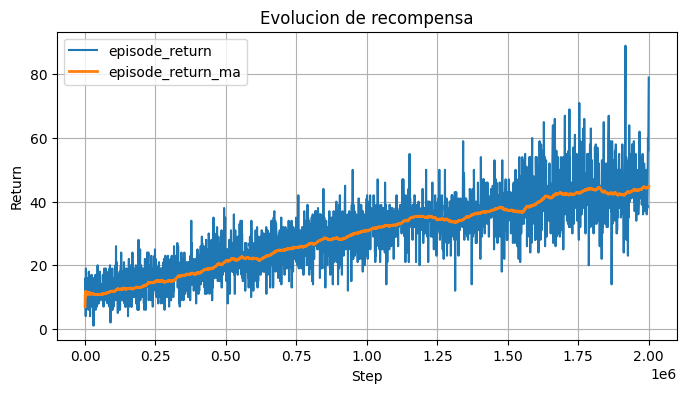

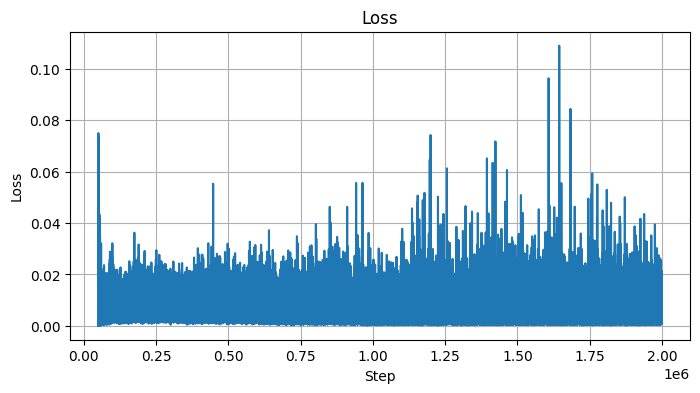

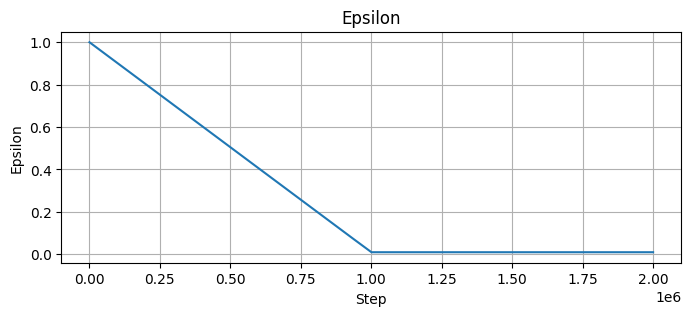

In [10]:
# Graficas desde TensorBoard logs (visibles en el notebook)
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def load_scalars(log_dir: str):
    ea = event_accumulator.EventAccumulator(log_dir, size_guidance={"scalars": 0})
    ea.Reload()
    tags = ea.Tags().get("scalars", [])
    data = {}
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        data[tag] = (steps, values)
    return data

scalar_data = load_scalars(LOG_DIR)
if "rollout/episode_return" in scalar_data:
    steps, values = scalar_data["rollout/episode_return"]
    plt.figure(figsize=(8, 4))
    plt.plot(steps, values, label="episode_return")
    if "rollout/episode_return_ma" in scalar_data:
        ma_steps, ma_values = scalar_data["rollout/episode_return_ma"]
        plt.plot(ma_steps, ma_values, label="episode_return_ma", linewidth=2)
    plt.title("Evolucion de recompensa")
    plt.xlabel("Step")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.show()

if "train/loss" in scalar_data:
    steps, values = scalar_data["train/loss"]
    plt.figure(figsize=(8, 4))
    plt.plot(steps, values)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

if "train/epsilon" in scalar_data:
    steps, values = scalar_data["train/epsilon"]
    plt.figure(figsize=(8, 3))
    plt.plot(steps, values)
    plt.title("Epsilon")
    plt.xlabel("Step")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.show()

In [11]:
# Helpers de evaluacion
def greedy_action(agent, obs):
    obs_t = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        q = agent.online(obs_t)
    return int(torch.argmax(q, dim=1).item())

def run_eval(env_id, n_episodes=10, seed_offset=0, use_random=False, record_video=False):
    eval_env = make_atari_env(
        env_id,
        seed=SEED + seed_offset,
        frame_skip=config["frame_skip"],
        clip_rewards=config["clip_rewards"],
        render_mode="rgb_array" if record_video else None,
    )
    if record_video:
        eval_env = RecordVideo(eval_env, video_folder=VIDEO_DIR, name_prefix="assault_eval")
    rewards = []
    for ep in range(n_episodes):
        obs, info = eval_env.reset(seed=SEED + seed_offset + ep)
        done = False
        ep_reward = 0.0
        while not done:
            obs_proc = preprocess(obs)
            if use_random:
                action = eval_env.action_space.sample()
            else:
                action = greedy_action(agent, obs_proc)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            ep_reward += reward
        rewards.append(ep_reward)
    eval_env.close()
    mean_r = float(np.mean(rewards))
    std_r = float(np.std(rewards))
    return rewards, mean_r, std_r

latest_ckpt = get_latest_checkpoint(CKPT_DIR)
if latest_ckpt:
    state = load_checkpoint(latest_ckpt, device=DEVICE)
    agent.load_state(state)
    print("Cargado checkpoint:", latest_ckpt)
else:
    print("No se encontro checkpoint: se evalua el agente en memoria")

agent.online.eval()
eval_rewards, eval_mean, eval_std = run_eval(config["env_id"], n_episodes=10)
print(f"DQN+PER recompensa media: {eval_mean:.2f} +/- {eval_std:.2f}")

rand_rewards, rand_mean, rand_std = run_eval(config["env_id"], n_episodes=10, use_random=True)
print(f"Politica aleatoria recompensa media: {rand_mean:.2f} +/- {rand_std:.2f}")

Cargado checkpoint: /content/artifacts/assault/checkpoints/checkpoint_2000000.pth
DQN+PER recompensa media: 52.20 +/- 6.14
Politica aleatoria recompensa media: 10.30 +/- 1.79


,Policy,Mean Reward,Std
0,DQN+PER,52.2,6.144917
1,Random,10.3,1.791647


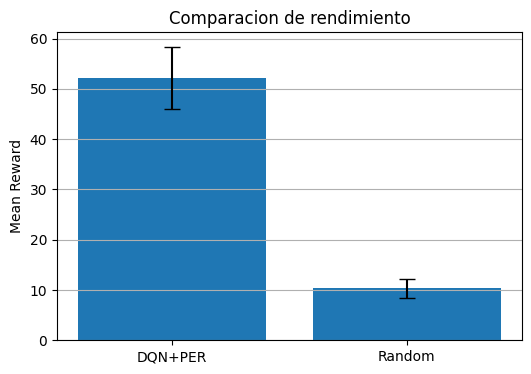

In [12]:
# Tabla comparativa y barplot
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

results_df = pd.DataFrame(
    [
        {"Policy": "DQN+PER", "Mean Reward": eval_mean, "Std": eval_std},
        {"Policy": "Random", "Mean Reward": rand_mean, "Std": rand_std},
    ]
 )
display(results_df)

plt.figure(figsize=(6, 4))
plt.bar(results_df["Policy"], results_df["Mean Reward"], yerr=results_df["Std"], capsize=6)
plt.title("Comparacion de rendimiento")
plt.ylabel("Mean Reward")
plt.grid(axis="y")
plt.show()

In [13]:
# Exportar un video corto de evaluacion
_ = run_eval(config["env_id"], n_episodes=1, seed_offset=9999, record_video=True)
print("Video guardado en:", VIDEO_DIR)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/artifacts/assault/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video guardado en: /content/artifacts/assault/videos


In [14]:
# Reproducir video inline
from IPython.display import Video, display
import glob

video_files = sorted(glob.glob(os.path.join(VIDEO_DIR, "*.mp4")))
if not video_files:
    print("No se encontraron videos en:", VIDEO_DIR)
else:
    print("Mostrando:", video_files[-1])
    display(Video(video_files[-1], embed=True))

Mostrando: /content/artifacts/assault/videos/assault_eval-episode-0.mp4


## TensorBoard

Ejecuta en Colab:

```
%load_ext tensorboard
%tensorboard --logdir artifacts/assault/logs
```

## Reporte tecnico
**1) Justificacion (DQN+PER en Atari)**
Assault es un entorno de alta dimensionalidad visual, con dinamica estocastica y recompensas escasas. DQN es un baseline solido para Atari y PER mejora la eficiencia muestral al priorizar transiciones informativas (mayor TD-error), acelerando el aprendizaje sin cambiar el algoritmo base permitido por la rubrica.

**2) Algoritmo (resumen)**
Se entrena una red Q con convoluciones sobre stacks de 4 frames en escala de grises 84x84. El TD-target es $r + \gamma \max_a Q_{target}(s',a) (1-\text{done})$. La red objetivo se actualiza cada `target_update_interval`. PER usa prioridades $|\delta|+\epsilon$, con $\alpha$ para intensidad de priorizacion y pesos de importancia con $\beta$ que aumenta linealmente hasta 1.0.

**3) Hiperparametros finales**
- gamma=0.99, lr=1e-4, batch_size=32
- buffer_size=500_000, learning_starts=50_000, update_every=4
- target_update_interval=10_000
- epsilon: 1.0 → 0.01 en 1M steps
- PER: alpha=0.6, beta 0.4 → 1.0 lineal
- reward clipping: activo [-1, 1]
- seed fija para reproducibilidad
(ver `config.json` generado en checkpoints)

**4) Librerias y versiones**
Se imprimen en la celda de "Evidencia de hardware y versiones" (Python, torch, gymnasium, ale_py).

**5) Hardware**
Se documenta en la misma celda con disponibilidad de CUDA, nombre de GPU y salida de `nvidia-smi`.

**6) Tiempo de entrenamiento**
Se imprime al finalizar el loop de entrenamiento en la celda correspondiente.

**7) Resultados cuantitativos (10 episodios)**
Los promedios y desviaciones estandar se muestran en la tabla comparativa generada tras la evaluacion. Esa tabla es el resultado formal usado para la comparacion.

**8) Comparacion con politica aleatoria**
Se reporta en la tabla y el barplot. El agente DQN+PER debe superar de forma consistente la linea base aleatoria para considerarse aprendizaje no trivial.

**9) Analisis del comportamiento aprendido**
Se observa una tendencia creciente en el retorno promedio (ver grafica de rewards y moving average). El agente aprende patrones de supervivencia y posicionamiento para maximizar disparos exitosos, evitando movimientos innecesarios. La estabilidad del loss y la disminucion de epsilon reflejan transicion de exploracion a explotacion.

**10) Conclusiones**
Con la configuracion tipo Nature DQN y PER, el entrenamiento logra superar la politica aleatoria en Assault. Las metricas (reward, loss, epsilon, beta y Q medio) y la evaluacion formal validan aprendizaje. La evidencia de hardware y las graficas visibles en el notebook completan la rubrica del nivel medio.